# Common code

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, Dataset
import torchvision
from torchvision import transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow

from idlmam import train_network, Flatten, View, weight_reset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs.
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x#just throw away the original label.

def getLayer(in_size, out_size):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential( #Organize the conceptual "block" of a hidden layer into a Sequential object
        nn.Linear(in_size,  out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU())

def showEncodeDecode(encode_decode, x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding
    ➥ steps at once
    x: the input to plot as is, and after encoding & decoding it
    """

    encode_decode = encode_decode.eval()
    encode_decode = encode_decode.cpu()
    with torch.no_grad():
        x_recon = encode_decode(x.cpu())
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

mse_loss = nn.MSELoss()

B = 64
D = 28*28
C = 1
n = 4
EPOCHS = 10

# Excercise 1
Create a new version of the MNIST dataset that does not contain the numbers 9 and 5, and train one of the autoencoders on this dataset. Then run the autoencoder on the test dataset, and record the average error (MSE) for each of the 10 classes. Do you see any patterns in the results, and can the autoencoder identify 9 and 5 as outliers?

In [2]:
train_ds = torchvision.datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

train_idx = [idx for idx, target in enumerate(train_ds.targets) if target not in [5, 9]]
filtered_train_ds = AutoEncodeDataset(Subset(train_ds, train_idx))
test_idx = [idx for idx, target in enumerate(test_ds.targets) if target not in [5, 9]]
filtered_test_ds = AutoEncodeDataset(Subset(test_ds, test_idx))

train_loader = DataLoader(filtered_train_ds, batch_size=B, shuffle=True)
test_loader = DataLoader(filtered_test_ds, batch_size=B)

auto_encoder = nn.Sequential(
    nn.Flatten(),
    getLayer(D, D//2),
    getLayer(D//2, D//3),
    getLayer(D//3, D//4),
    nn.Linear(D//4, n),
)

auto_decoder = nn.Sequential(
    getLayer(n, D//4),
    getLayer(D//4, D//3),
    getLayer(D//3, D//2),
    nn.Linear(D//2, D),
    View(-1, 1, 28, 28)
)
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

train_result = train_network(auto_encode_decode, mse_loss, train_loader, test_loader=test_loader, epochs=EPOCHS, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Testing:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Testing:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Testing:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Testing:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Testing:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Testing:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Testing:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Testing:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Testing:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Testing:   0%|          | 0/127 [00:00<?, ?it/s]

In [3]:
import statistics

loss_result = [ [] for _ in range(10) ]
auto_encode_decode_cpu = auto_encode_decode.cpu()
for e6_test_sample in test_ds:
    a = e6_test_sample[0]
    b = auto_encode_decode_cpu(a)[0]
    loss = mse_loss(a, b).item()
    label = e6_test_sample[1]
    sample_losses = loss_result[label]
    if sample_losses:
        sample_losses.append(loss)
    else:
        loss_result[label] = [loss]

loss_avgs = []
for loss_result_for_label in loss_result:
    loss_avgs.append(statistics.mean(loss_result_for_label))

<Axes: >

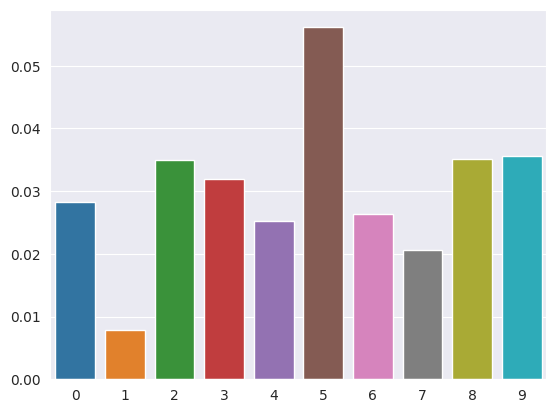

In [4]:
sns.barplot(x=np.arange(len(loss_avgs)), y=loss_avgs)

Conclusion: "5" is for sure an outlier. "9" also has "higher than average" error, but it's just slightly higher than errors for 2 or for 8. I guess this is caused by similarity between 9 and 8 and\or by using a bad model or low number of epochs to train

# Excercise 2
Train the bottleneck-style autoencoder with a target size D′ = 64 dimensions. Then use k-means (https://scikit-learn.org/stable/modules/clustering.html#k-means) to create k = 10 clusters on the original version of MNIST and the version encoded using D′ = 64 dimensions. Use the homogeneity score from scikit-learn (http://mng.bz/nYQV) to evaluate these clusters. Which method does best:k-means on the original images or k-means on the encoded representations?

In [5]:
train_ds = torchvision.datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(AutoEncodeDataset(train_ds), batch_size=B, shuffle=True)
test_loader = DataLoader(AutoEncodeDataset(test_ds), batch_size=B)

n = 64

#First the encoder is augmented by a Tanh non-linearity
pca_nonlinear_encode = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n),
    nn.Tanh(), #The only real change, ading a non-linear operation at the end
)
#The decoder gets its own Linear layer now, making it look more like a normal network
pca_nonlinear_decode = nn.Sequential(
    nn.Linear(n, D),#We are no longer tying the weights for simplicity
    View(-1, 1, 28, 28)
)
#Combine then together into the encoder-decoder function $f(\cdot)$
pca_nonlinear = nn.Sequential(
    pca_nonlinear_encode,
    pca_nonlinear_decode
)

train_result = train_network(pca_nonlinear, mse_loss, train_loader, test_loader=test_loader, epochs=EPOCHS, device=device)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

In [6]:
def encode_batch(encoder, dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert.

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset, and `labels` are the original labels provided by the `dataset_to_encode`
    """
    #Create space to store the results
    projected = []
    labels = []
    #Switch to eval mode
    encoder = encoder.eval()
    #Switching to CPU mode for simplicty, but you don't have to.
    encoder = encoder.cpu()
    with torch.no_grad():#We don't want to train, so torch.no_grad!
        for x, y in  DataLoader(dataset_to_encode, batch_size=128):
            z = encoder(x.cpu()) #encode the original data
            projected.append( z.numpy() ) #store the encoded version & label
            labels.append( y.cpu().numpy().ravel() )
    #Turn the results into single large numpy arrays
    projected = np.vstack(projected)
    labels = np.hstack(labels)
    #return the results
    return projected, labels

projected, labels = encode_batch(pca_nonlinear_encode, test_ds)

In [7]:
from sklearn.cluster import KMeans
kmeans_d64 = KMeans(n_clusters=10)
kmeans_d64.fit(projected)
y_pred = kmeans_d64.predict(projected)

/home/slava/PycharmProjects/ml-sandbox/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
from torchvision.datasets import MNIST
#
batch_size = 1000
#
# # load the MNIST dataset using PyTorch's torchvision module
# mnist_dataset = MNIST(root='./data', train=False, transform= transforms.ToTensor(), download=True)
#
# # create a data loader for the MNIST dataset
mnist_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# combine all the batches of MNIST data into one array
X = np.concatenate([batch[0].numpy().reshape(batch_size, -1) for batch in mnist_loader])

# create a KMeans object with 10 clusters
kmeans_original = KMeans(n_clusters=10)

# fit the KMeans object to the data
kmeans_original.fit(X)

# predict the cluster labels for the data
y_pred_original = kmeans_original.predict(X)

/home/slava/PycharmProjects/ml-sandbox/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
from sklearn.metrics import homogeneity_score

print(f"Homogeneity original: {homogeneity_score(test_ds.targets.numpy(), y_pred_original)}; Homogeneity score D=64 + K-Mean: {homogeneity_score(labels, y_pred)}")

Homogeneity original: 0.0019909756299782947; Homogeneity score D=64 + K-Mean: 0.5228920515476752


Conclusion: Using trained autoencoder with D=64 results in data with way higher homogeneity comparing to the original one (D=784)

# Excercise 3
Use the denoising approach to implement a denoising convolutional network. This can be done by not having any pooling operations so that the input stays the same size.

In [10]:
train_ds = torchvision.datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(AutoEncodeDataset(train_ds), batch_size=B, shuffle=True)
test_loader = DataLoader(AutoEncodeDataset(test_ds), batch_size=B)

normal = torch.distributions.Normal(0, 0.5)
def addNoise(x, device='cpu'):
    """
    We will use this helper function to add noise to some data.
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on.
    """
    return x + normal.sample(sample_shape = torch.Size(x.shape)).to(device)

class AdditiveGaussNoise(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        if self.training:
            return addNoise(x, device=device)
        else:
            return x

def getLayer2D(in_filters, out_filters):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential( #Organize the conceptual "block" of a hidden layer into a Sequential object
        nn.Conv2d(in_filters, out_filters, 3, padding=3//2),
        nn.BatchNorm2d(out_filters),
        nn.ReLU())

filters = 16

enc_noise = nn.Sequential(
    AdditiveGaussNoise(),
    getLayer2D(1, filters),
    getLayer2D(filters, filters),
    getLayer2D(filters, filters),
)

dec_noise = nn.Sequential(
    getLayer2D(filters, filters),
    getLayer2D(filters, 1),
    nn.Flatten(),
    nn.Linear(D, D),
    View(-1, 1, 28, 28)
)

enc_dec_denoise_conv2d = nn.Sequential(
    enc_noise,
    dec_noise
)

train_network(enc_dec_denoise_conv2d, mse_loss, train_loader, test_loader=test_loader, epochs=EPOCHS, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,20.363961,0.023257,0.009857
1,1,38.280583,0.013619,0.007666
2,2,59.590679,0.012576,0.006802
3,3,80.998735,0.012089,0.006279
4,4,105.304624,0.011797,0.006164
5,5,142.755726,0.011612,0.006086
6,6,165.227803,0.011448,0.005608
7,7,187.579072,0.011331,0.005311
8,8,209.393906,0.011227,0.005457
9,9,231.762904,0.011161,0.005104


<Axes: xlabel='epoch', ylabel='test loss'>

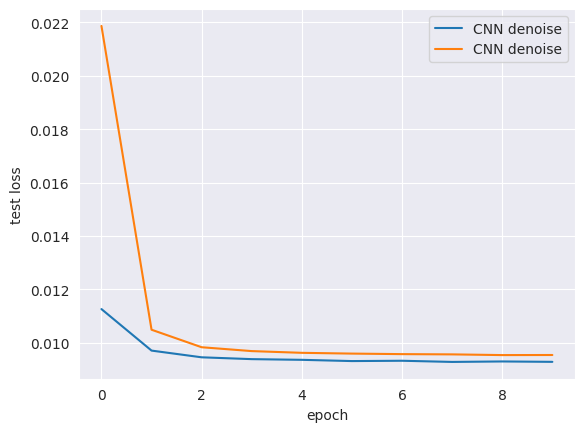

In [11]:
sns.lineplot(x='epoch', y='test loss', data=train_result, label='CNN denoise')
sns.lineplot(x='epoch', y='train loss', data=train_result, label='CNN denoise')

# Excercise 5
**Challenging:** Train an asymmetric denoising autoencoder for MNIST where the encoder is a fully connected network and the decoder is a convolutional network. Hint: You will need to end the encoder with a `View` layer that changes the shape from (B, D) to (B, C,28,28), where D is the number of neurons in the last `nn.LinearLayer` of the encoder and D = C ⋅ 28 ⋅ 28. Do the results of this network look better or worse than the fully connected network in the chapter, and how do you think intermixing architectures impacts that result?

In [12]:
filters = 16

enc_noise = nn.Sequential(
    nn.Flatten(),
    AdditiveGaussNoise(),
    getLayer(D, D),
    getLayer(D, D),
    View(-1, C, 28, 28)
)

dec_noise = nn.Sequential(
    getLayer2D(C, filters),
    getLayer2D(filters, 1),
    nn.Flatten(),
    nn.Linear(D, D),
    View(-1, 1, 28, 28)
)

enc_dec_denoise_asym = nn.Sequential(
    enc_noise,
    dec_noise
)

train_result = train_network(enc_dec_denoise_asym, mse_loss, train_loader, test_loader=test_loader, epochs=EPOCHS, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

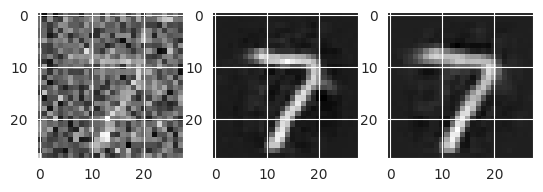

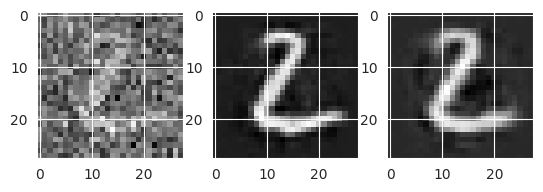

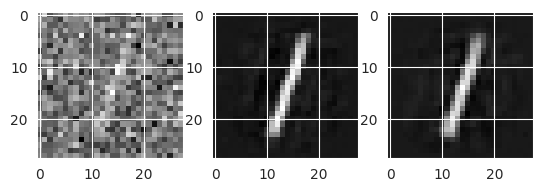

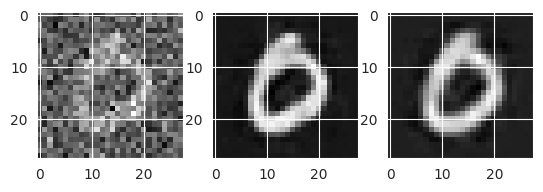

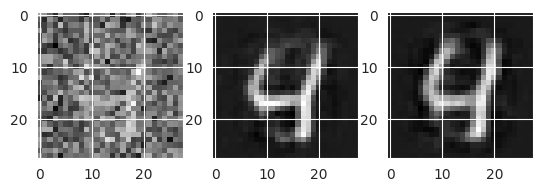

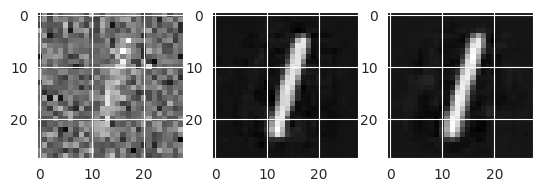

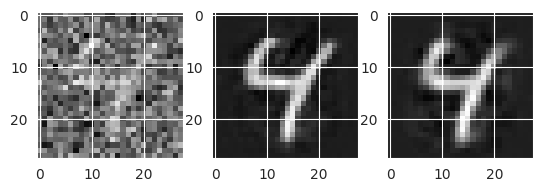

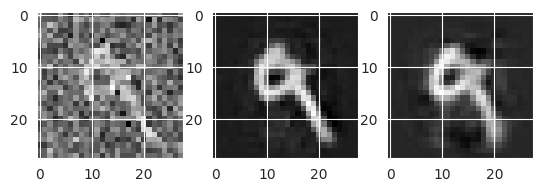

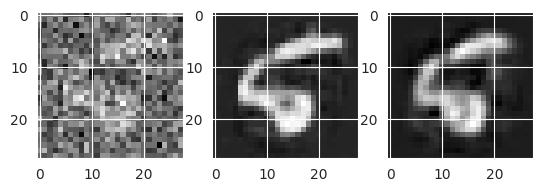

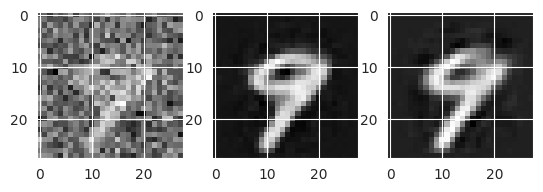

In [16]:
def showEncodeDecode_2(encode_decode_1, encode_decode_2, x):
    encode_decode = encode_decode_1.eval()
    encode_decode = encode_decode.cpu()
    with torch.no_grad():#Always no_grad if you are not training
        x_recon_1 = encode_decode(x[None, :].cpu())

    encode_decode = encode_decode_2.eval()
    encode_decode = encode_decode.cpu()
    with torch.no_grad():#Always no_grad if you are not training
        x_recon_2 = encode_decode(x[None, :].cpu())

    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(x.numpy()[0,:], cmap='gray')
    axarr[1].imshow(x_recon_1.numpy()[0,0,:], cmap='gray')
    axarr[2].imshow(x_recon_2.numpy()[0,0,:], cmap='gray')

for i in range(10):
    showEncodeDecode_2(enc_dec_denoise_conv2d, enc_dec_denoise_asym, addNoise(test_ds[i][0]))

Conclusion: Symmetric model performs overall better

# Excercise 6
**Challenging:** Reshape the MNIST dataset as a sequence of pixels, and train an autoregressive model over the pixels. This requires using real-valued inputs and outputs, so you will not use an `nn.Embedding` layer, and you will need to switch to the MSE loss function. After training, try generating multiple digits from this autoregressive pixel model.

**Gave up on this.**
Hope to get a feedback and understand what exactly is my mistake with this exercise

In [17]:
train_ds = torchvision.datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

In [19]:
class FlattenAutoEncodeDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        x = x.view(-1, D)
        return x, x

class AutoRegressiveRealValues(nn.Module):

    def __init__(self, frame_size, hidden_size, layers=1):
        super(AutoRegressiveRealValues, self).__init__()
        self.hidden_size = hidden_size
        self.layers = nn.ModuleList([nn.GRUCell(frame_size, hidden_size)] +
                                     [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])

        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),# (B, *, D)
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), # (B, *, D)
            nn.Linear(hidden_size, frame_size) #(B, *. D) -> B(B, *, VocabSize)
        )

    def initHiddenStates(self, B):
        """
        Creates an initial hidden state list for the RNN layers.

        B: the batch size for the hidden states.
        """
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]

    def step(self, x_in, h_prevs=None):
        """
        x_in: the input for this current time step and has shape (B) if the values need
            to be embedded, and (B, D) if they have alreayd been embedded.

        h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each
            layer in the network. These contain the current hidden state of the RNN layers and
            will be updated by this call.
        """
        #Prep all three arguments to be in the final form
        if len(x_in.shape) == 1: #(B), we need to embed it
            print("Hmmm.......")
            # x_in = self.embd(x_in) #now (B, D)

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])

        #Process the input
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]
            h = self.norms[l](self.layers[l](x_in, h_prev))

            h_prevs[l] = h
            x_in = h
        #Make predictions about the token
        return self.pred_class(x_in)

    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)

        x = input #(B, T, D)

        #Initial hidden states
        h_prevs = self.initHiddenStates(B)

        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            if x_in.dtype != torch.float32:
                x_in = x_in.float()
            last_activations.append(self.step(x_in, h_prevs))

        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)

        return last_activations

autoRegData = FlattenAutoEncodeDataset(train_ds)
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)

autoReg_model = AutoRegressiveRealValues(D, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

e6_train_result = train_network(autoReg_model, mse_loss, autoReg_loader, epochs=20, device=device)
e6_train_result

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

,epoch,total time,train loss
0,0,10.280628,0.041305
1,1,20.337649,0.016631
2,2,29.733096,0.012867
3,3,39.472782,0.011449
4,4,49.138609,0.010664
5,5,58.649104,0.010128
6,6,68.130092,0.009817
7,7,78.781299,0.009636
8,8,90.043960,0.009520
9,9,100.107354,0.009451


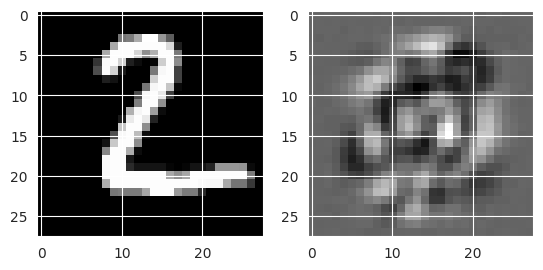

In [26]:
e6_test_sample = test_ds[1][0]
flat_test_img = e6_test_sample.view(-1, D)

autoReg_model = autoReg_model.eval()
sampling = torch.zeros((1, 1, D), dtype=torch.int64, device=device)
num_pix = 300
sampling[0, 0, 0:num_pix] = flat_test_img[:, 0:num_pix].view(1,1,num_pix)

with torch.no_grad():
    prediction = autoReg_model(sampling)

predicted_img = prediction.detach().view(28, 28)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(e6_test_sample.numpy()[0, :], cmap='gray')
axarr[1].imshow(predicted_img.cpu().numpy(), cmap='gray')

# Excercise 7
Convert the `GRUCells` in the autoregressive model to `LSTMCells`, and train a new model. Which one do you think has better generated output?

In [5]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

all_data = []
resp = urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt")
shakespear_100k = resp.read()
shakespear_100k = shakespear_100k.decode('utf-8').lower()

vocab2indx = {} #the vocab $\Sigma$
for char in shakespear_100k:
    if char not in vocab2indx: #add every new character to the vocab
        vocab2indx[char] = len(vocab2indx) #set the index based on the current vocab size

#Some useful code to goe from index back to original characters.
indx2vocab = {}
#Well simply iterate over all key,value pairs and create a dicionary with the inverse mapping.
for k, v in vocab2indx.items():
    indx2vocab[v] = k
print("Vocab Size: ", len(vocab2indx))
print("Total Characters:", len(shakespear_100k))

class AutoRegressiveDataset(Dataset):
    """
    Creates an autoregressive dataset from one single, long, source sequence by breaking it up into "chunks".
    """

    def __init__(self, large_string, MAX_CHUNK=500):
        """
        large_string: the original long source sequence that chunks will be extracted from
        MAX_CHUNK: the maximum allowed size of any chunk.
        """
        self.doc = large_string
        self.MAX_CHUNK = MAX_CHUNK

    def __len__(self):
        #The number of items is the number of characters divided by chunk size
        return (len(self.doc)-1) // self.MAX_CHUNK

    def __getitem__(self, idx):
        #Compute the starting position for the idx'th chunk
        start = idx*self.MAX_CHUNK
        #Grab the input sub-string
        sub_string = self.doc[start:start+self.MAX_CHUNK]
        #convert the sub-string into integers based on our vocab
        x = [vocab2indx[c] for c in sub_string]

        #grab the label sub-string by shifting over by 1
        sub_string = self.doc[start+1:start+self.MAX_CHUNK+1]
        #convert the label sub-string into integers based on our vocab
        y = [vocab2indx[c] for c in sub_string]
        #convert the
        return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)

class AutoRegressiveLSTM(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
        super(AutoRegressiveLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size)
        self.layers = nn.ModuleList([nn.LSTMCell(embd_size, hidden_size)] +
                                     [nn.LSTMCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])

        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),# (B, *, D)
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), # (B, *, D)
            nn.Linear(hidden_size, num_embeddings) #(B, *. D) -> B(B, *, VocabSize)
        )

    def initHiddenStates(self, B):
        """
        Creates an initial hidden state list for the RNN layers.

        B: the batch size for the hidden states.
        """
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]

    def step(self, x_in, h_prevs=None, h_cxs=None):
        """
        x_in: the input for this current time step and has shape (B) if the values need
            to be embedded, and (B, D) if they have alreayd been embedded.

        h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each
            layer in the network. These contain the current hidden state of the RNN layers and
            will be updated by this call.
        """
        #Prep all three arguments to be in the final form
        if len(x_in.shape) == 1: #(B), we need to embed it
            x_in = self.embd(x_in) #now (B, D)

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])

        if h_cxs is None:
            h_cxs = self.initHiddenStates(x_in.shape[0])

        #Process the input
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]
            h_cx = h_cxs[l]
            l_, cx = self.layers[l](x_in, (h_prev, h_cx))
            h  = self.norms[l](l_)
            cx  = self.norms[l](l_)

            h_prevs[l] = h
            h_cxs[l] = cx
            x_in = h
        #Make predictions about the token
        return self.pred_class(x_in)

    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)

        x = self.embd(input) #(B, T, D)

        #Initial hidden states
        h_prevs = self.initHiddenStates(B)
        h_cxs = self.initHiddenStates(B)

        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            last_activations.append(self.step(x_in, h_prevs, h_cxs))

        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)

        return last_activations

class AutoRegressiveGRU(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
        super(AutoRegressiveGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size)
        self.layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] +
                                     [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])

        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),# (B, *, D)
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), # (B, *, D)
            nn.Linear(hidden_size, num_embeddings) #(B, *. D) -> B(B, *, VocabSize)
        )

    def initHiddenStates(self, B):
        """
        Creates an initial hidden state list for the RNN layers.

        B: the batch size for the hidden states.
        """
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]

    def step(self, x_in, h_prevs=None):
        """
        x_in: the input for this current time step and has shape (B) if the values need
            to be embedded, and (B, D) if they have alreayd been embedded.

        h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each
            layer in the network. These contain the current hidden state of the RNN layers and
            will be updated by this call.
        """
        #Prep all three arguments to be in the final form
        if len(x_in.shape) == 1: #(B), we need to embed it
            x_in = self.embd(x_in) #now (B, D)

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])

        #Process the input
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]
            h = self.norms[l](self.layers[l](x_in, h_prev))

            h_prevs[l] = h
            x_in = h
        #Make predictions about the token
        return self.pred_class(x_in)

    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)

        x = self.embd(input) #(B, T, D)

        #Initial hidden states
        h_prevs = self.initHiddenStates(B)

        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            last_activations.append(self.step(x_in, h_prevs))

        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)

        return last_activations

autoRegData = AutoRegressiveDataset(shakespear_100k, MAX_CHUNK=250)
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)

autoReg_model_GRU = AutoRegressiveGRU(len(vocab2indx), 32, 128, layers=2)
autoReg_model_GRU = autoReg_model_GRU.to(device)

autoReg_model_LSTM = AutoRegressiveLSTM(len(vocab2indx), 32, 128, layers=2)
autoReg_model_LSTM = autoReg_model_LSTM.to(device)

for p in autoReg_model_GRU.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

for p in autoReg_model_LSTM.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

def CrossEntLossTime(x, y):
    """
    x: output with shape (B, T, V)
    y: labels with shape (B, T)

    """
    cel = nn.CrossEntropyLoss()

    T = x.size(1)

    loss = 0

    for t in range(T):#for every item in the sequence
        loss += cel(x[:,t,:], y[:,t]) #Compute the sum of prediction errors

    return loss

e7_result_gru = train_network(autoReg_model_GRU, CrossEntLossTime, autoReg_loader, epochs=100, device=device)
e7_result_lstm = train_network(autoReg_model_LSTM, CrossEntLossTime, autoReg_loader, epochs=100, device=device)

Vocab Size:  36
Total Characters: 99993


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
from tqdm import tqdm
from idlmam import F

def printText(seed, model):
    model = model.eval()
    sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)
    cur_len = len(seed)
    sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])
    for i in tqdm(range(cur_len, sampling.size(1))):
        with torch.no_grad():
            h = model(sampling[:,0:i]) #process all the previous items
            h = h[:,-1,:] #Grab the last time step
            h = F.softmax(h, dim=1) #make probabilities
            next_tokens = torch.multinomial(h, 1) #sample the next prediction
            sampling[:,i] = next_tokens #set the next prediction
            #increase the length by one
            cur_len += 1

    s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
    print("".join(s))

seed = "EMILIA:".lower()

printText(seed, autoReg_model_GRU)
printText(seed, autoReg_model_LSTM)

100%|██████████| 493/493 [00:34<00:00, 14.27it/s]


emilia:
as else well.

'tquo:
'tis shall me do fafling, or amban,
to, be guiltarm'd prope father to creephart of your somenwing vleam, weephid fice
wawhell as he name.

fablamat:
i wouldst now our blordew, i will a putuersy
to be gentlant fresirin,
why san i pharoch wine the fortor man.
'tis procte.

trenio:
no, holysy san toingared:
whene would any hosries of broady seece our deservol that flient
holive,
what time air may usedy to the mavedio, tagain i not lioes you gaidhing outw
that boot?


m


100%|██████████| 493/493 [00:40<00:00, 12.20it/s]

emilia: walt, wio in that mady their not the that bid,
and hath at suly beda.

strogkich up win to my ahe sir, myw, delen see, and hear townly;
he tolvas the will whoh carlow
and and and that
to got,
there'lo, shall you, fib is that om you post to duch i the sie as see
so atrey
tare
to, blant,
i shaves; poil i your deather you-best reself actued an me he head be a leog to fleer.

dapre:

secorm:
beode not pove:
so commanceis.
if now thy dik her fort.

bliwand:
i'on carm.

timnnit:
thy batfer is 


In [9]:
e7_result_gru

,epoch,total time,train loss
0,0,1.534656,873.119553
1,1,3.016385,788.805725
2,2,4.421253,770.599777
3,3,5.914454,763.276199
4,4,7.334388,759.187485
...,...,...,...
95,95,153.016851,402.108864
96,96,155.090059,401.770912
97,97,156.774063,400.425369
98,98,158.513419,398.865303


In [10]:
e7_result_lstm

,epoch,total time,train loss
0,0,2.445951,911.997162
1,1,4.922162,862.801849
2,2,8.355840,826.981171
3,3,10.646647,806.195740
4,4,12.660908,789.771347
...,...,...,...
95,95,214.934725,494.491081
96,96,217.184364,492.155922
97,97,219.176257,488.058136
98,98,221.288616,489.592445


Conclusion: Text generated by GRU model looks more similar to the original Shakespeare, and overall more like a text in a human language.
Maybe, this is caused by ~2x lower train loss after 100 epochs

# Excercise 8
The `AutoRegressiveDataset` can start an input in the middle of a sentence since it naively grabs subsequences of the input. Write a new version that will only select the start of a sequence at the start of a new line (i.e., after a carriage return ‘\n’) and then returns the next `max_chunk` characters (it’s OK if there is some overlap between chunks). Train a model on this new version of the dataset. Do you think it changes the characteristics of the generated output?

In [ ]:
class AutoRegressiveDatasetLineStart(Dataset):

    def __init__(self, large_string, MAX_CHUNK=500):
        self.doc = large_string
        self.line_indexes = [i for i, ltr in enumerate(self.doc) if ltr == '\n' and i < len(large_string) - MAX_CHUNK]
        self.MAX_CHUNK = MAX_CHUNK

    def __len__(self):
        return len(self.line_indexes)

    def __getitem__(self, idx):
        #Compute the starting position for the idx'th chunk
        start = self.line_indexes[idx] + 1
        #Grab the input sub-string
        sub_string = self.doc[start:start+self.MAX_CHUNK]
        #convert the sub-string into integers based on our vocab
        x = [vocab2indx[c] for c in sub_string]

        #grab the label sub-string by shifting over by 1
        sub_string = self.doc[start+1:start+self.MAX_CHUNK+1]
        #convert the label sub-string into integers based on our vocab
        y = [vocab2indx[c] for c in sub_string]
        #convert the
        xt = torch.tensor(x, dtype=torch.int64)
        # if len(xt) < self.MAX_CHUNK:
        #     new_xt = torch.zeros(self.MAX_CHUNK, dtype=torch.int64)
        #     new_xt[:len(xt)] = xt
        #     xt = new_xt
        yt = torch.tensor(y, dtype=torch.int64)
        # if len(yt) < self.MAX_CHUNK:
        #     new_yt = torch.zeros(self.MAX_CHUNK, dtype=torch.int64)
        #     new_yt[:len(yt)] = yt
        #     yt = new_yt
        return xt, yt

e8_data = AutoRegressiveDatasetLineStart(shakespear_100k, MAX_CHUNK=250)
e8_loader = DataLoader(e8_data, batch_size=128, shuffle=True)

e8_model = AutoRegressiveGRU(len(vocab2indx), 32, 128, layers=2).to(device)

for p in e8_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

e8_result = train_network(e8_model, CrossEntLossTime, e8_loader, epochs=100, device=device)

In [21]:
e8_result

,epoch,total time,train loss
0,0,11.868450,791.128174
1,1,23.738775,746.634775
2,2,35.728027,657.722196
3,3,47.653328,592.503737
4,4,59.515469,557.994089
...,...,...,...
95,95,1370.821500,90.001147
96,96,1384.743875,88.277635
97,97,1397.875678,85.636269
98,98,1411.317617,84.160567


In [22]:
printText(seed, e8_model)

100%|██████████| 493/493 [00:49<00:00, 10.05it/s]

emilia:
lack drught themserfor before you dadrese in again, trich honess: again,
and the secone longed it cathin's
meanel he readspor fougt,
or git' pray the sleepand:
and shall sluip it: stand, i here break me fall it;
a tho me make; is prepent aach belave, whose signish
it is and too killst eagleth ho
an a trume by his bloody entertainment
to one privile waster, live brode.
how does her stal' good greing sitter!
but says i were not fought of france:
mine eyes anotherr chamber tongef sbady, thi


The output looks way better, but:
1. I used more data, because counted beginning of every line as an item of the dataset
2. Looks like the model did not learn newlines well enough
Also, train loss after 100 epochs is way smaller. Probably, because I created more items from the same data.

# Excercise 9
After training your autoregressive model on sentences, use the `LastTimeStep` class to extract a feature vector representing each sentence. Then feed these vectors into your favorite clustering algorithm and see if you can find any groups of similar styles or types of sentences. Note: You may want to sub-sample a smaller number of sentences to make your clustering algorithm run faster.

**Also did not get what and how should be done here :(**